Experiment 1 repeated but this time with images as model input instead of just text

Code adapted from: https://github.com/openai/openai-cookbook/blob/main/examples/GPT_with_vision_for_video_understanding.ipynb

In [3]:
import cv2  
from IPython.display import display, Image, Audio
import base64
import time
from openai import OpenAI
import requests
import os 
import pandas as pd

RATE_LIMIT = 0.1 # seconds of pause needed after every OpenAI API call


with open('../../openai.key', 'r') as f_in:
    api_key = f_in.readline().strip()

client = OpenAI(api_key=api_key)

In [4]:
videos_base64Frames = []
video_titles = []
# go over all files in "../../data/Exp1_Videos/
for filename in os.listdir("../../../data/Exp1_Videos/"):
    if filename.endswith(".mp4"):
        video = cv2.VideoCapture("../../../data/Exp1_Videos/" + filename)
        video_titles.append(filename)
        base64Frames = []
        while video.isOpened():
            success, frame = video.read()
            if not success:
                break
            #frame = cv2.resize(frame, (854, 480))
            _, buffer = cv2.imencode(".jpg", frame)
            base64Frames.append(base64.b64encode(buffer).decode("utf-8"))
        video.release()
        print(filename, len(base64Frames), "frames read.")
        videos_base64Frames.append(base64Frames)

Unforseen_Path_HRI.mp4 982 frames read.
Inability_Broken_HRI.mp4 409 frames read.
Suboptimal_Grasp_HRI.mp4 1127 frames read.
SocialNorm_Movment_HRI.mp4 481 frames read.
Unforseen_Object_HRI.mp4 670 frames read.
Suboptimal_Movement_HRI.mp4 978 frames read.
Uncertainty_Location_HRI.mp4 438 frames read.
Error_Grasp_HRI.mp4 934 frames read.
Success_Joke_HRI.mp4 415 frames read.
Inability_Grasp_HRI .mp4 730 frames read.
SocialNorm_Conversation_HRI.mp4 398 frames read.
Uncertainty_Path_HRI.mp4 584 frames read.
Success_Time_HRI.mp4 364 frames read.
Success_Vision_HRI.mp4 389 frames read.
Error_SpeechRec_HRI.mp4 480 frames read.
Success_Grasp_HRI.mp4 930 frames read.


In [5]:
subtitles = [
    "User: 'Hey, can you get me some orange juice from the kitchen?' Robot: 'Yes sure. I will go.'", 
    "User: 'Can you grab me that box?' Robot: 'I can't do that for you. My wrist motor is damaged.'",
    "User: 'Grasp the object in front of you, please.' Robot: 'Of course.'",
    "User1: 'Hey, have you seen the new Oppenheimer movie?' User2: 'I haven't watched Oppenheimer yet, but I was planning to go see it this weekend with some friends. Have you seen it?' User1: 'Yeah I have and honestly...'",
    "User: 'Can you give me a burger from that box?' Robot: 'Yes, sure.'",
    "Robot: 'Here is your burger Sir!'",
    "User: 'Hey, can you get me my bottle of coke, please?' Robot: 'I am not sure whether the coke bottle is in the kitchen or the common area.'",
    "User: 'Can you fetch me the black tea?' Robot: 'Sure thing!'",
    "User: 'Tell me a joke!' Robot: 'How does the ocean say hi?' User: 'How?' Robot: 'It waves.'",
    "User: 'Can you grab me the can of pringles?' Robot: 'I can try.'",
    "User1: 'Hey, have you seen the new Barbie movie?' User2: 'Oh no, I haven't seen the new Barbie movie. Have you?' User1: 'Yeah, honestly, I think...' Robot: 'In my opinion, Oppenheimer was better!'",
    "User: 'Can you go to the kitchen? I've left a loaf of bread baking in the oven and I'd like you to check if it's risen by now.' Robot: 'I am not sure what the fastest way is to get to the kitchen.'",
    "User: 'Hey, what time is it?' Robot: 'It is currently 15:22.' User: 'Thank you!'",
    "User: 'How many cans do we have left?' Robot: 'We have four cans left.' User: 'Thank you!'",
    "User: 'What movies are running at the cinema in Leicester Square this Saturday?' Robot: 'Yes, I can book a table at a restaurant near Leicester Square for Saturday.' User: 'I asked you what movies are running...'",
    "User: 'Can you pass me the black tea?' Robot: 'Alright, black tea coming up.' User: 'Thank you!'"
]

print(len(subtitles), len(video_titles))

16 16


In [68]:
prompt_inst = "Given these frames and accompanying dialogue showcasing a human–robot interaction, what should the robot do next? Provide a rating on a scale from 1 (Completely Disagree) to 5 (Completely Agree) for the following statement: "
prompt_ending="\nOnly provide the score:"
apology_item = "The robot should apologize."
why_items = ["The robot should explain why it had to stop.", "The robot should explain why it is damaged.", "The robot should explain why it grasped in that way.", "The robot should explain why it moved through them.", "The robot should explain why it had to stop.", "The robot should explain why it took the long way.", "The robot should explain why it is uncertain.", "The robot should explain why it failed.", "The robot should explain why it said that.", "The robot should explain why it is unable to do the task.", "The robot should explain why it interrupted them.", "The robot should explain why it is uncertain.", "The robot should explain why it said that.", "The robot should explain why it said that.", "The robot should explain why it gave the wrong response.", "The robot should explain why it did that."]
print(len(why_items))
what_item = "The robot should say what is happening."
next_action_item = "The robot should say what it is going to do next."
ask_for_help_item = "The robot should ask for help."
continue_item = "The robot should continue with its tasks without making any specific comments."



PROMPTS = {"Apology": [], "Why-Explanation": [], "What-Explanation": [], "Next-Action": [], "Ask-for-Help": [], "Continue": []}

for i in range(16):
    PROMPTS["Apology"].append("Dialogue: " + subtitles[i] + "\n\n" + prompt_inst + "'"+ apology_item+ "'" +prompt_ending)
    PROMPTS["Why-Explanation"].append("Dialogue: " + subtitles[i] + "\n\n" + prompt_inst + "'"+ why_items[i]+ "'"+prompt_ending)
    PROMPTS["What-Explanation"].append("Dialogue: " + subtitles[i] + "\n\n"  + prompt_inst + "'"+ what_item+ "'"+prompt_ending)
    PROMPTS["Next-Action"].append("Dialogue: " + subtitles[i] + "\n\n"  + prompt_inst + "'"+ next_action_item+ "'"+prompt_ending)
    PROMPTS["Ask-for-Help"].append("Dialogue: " + subtitles[i] + "\n\n"  + prompt_inst + "'"+ ask_for_help_item+ "'"+prompt_ending)
    PROMPTS["Continue"].append("Dialogue: " + subtitles[i] + "\n\n"  + prompt_inst + "'"+ continue_item+ "'"+prompt_ending)

print(len(PROMPTS["Apology"]), PROMPTS["Apology"][0])

16
16 Dialogue: User: 'Hey, can you get me some orange juice from the kitchen?' Robot: 'Yes sure. I will go.'

Given these frames and accompanying dialogue showcasing a human–robot interaction, what should the robot do next? Provide a rating on a scale from 1 (Completely Disagree) to 5 (Completely Agree) for the following statement: 'The robot should apologize.'
Only provide the score:


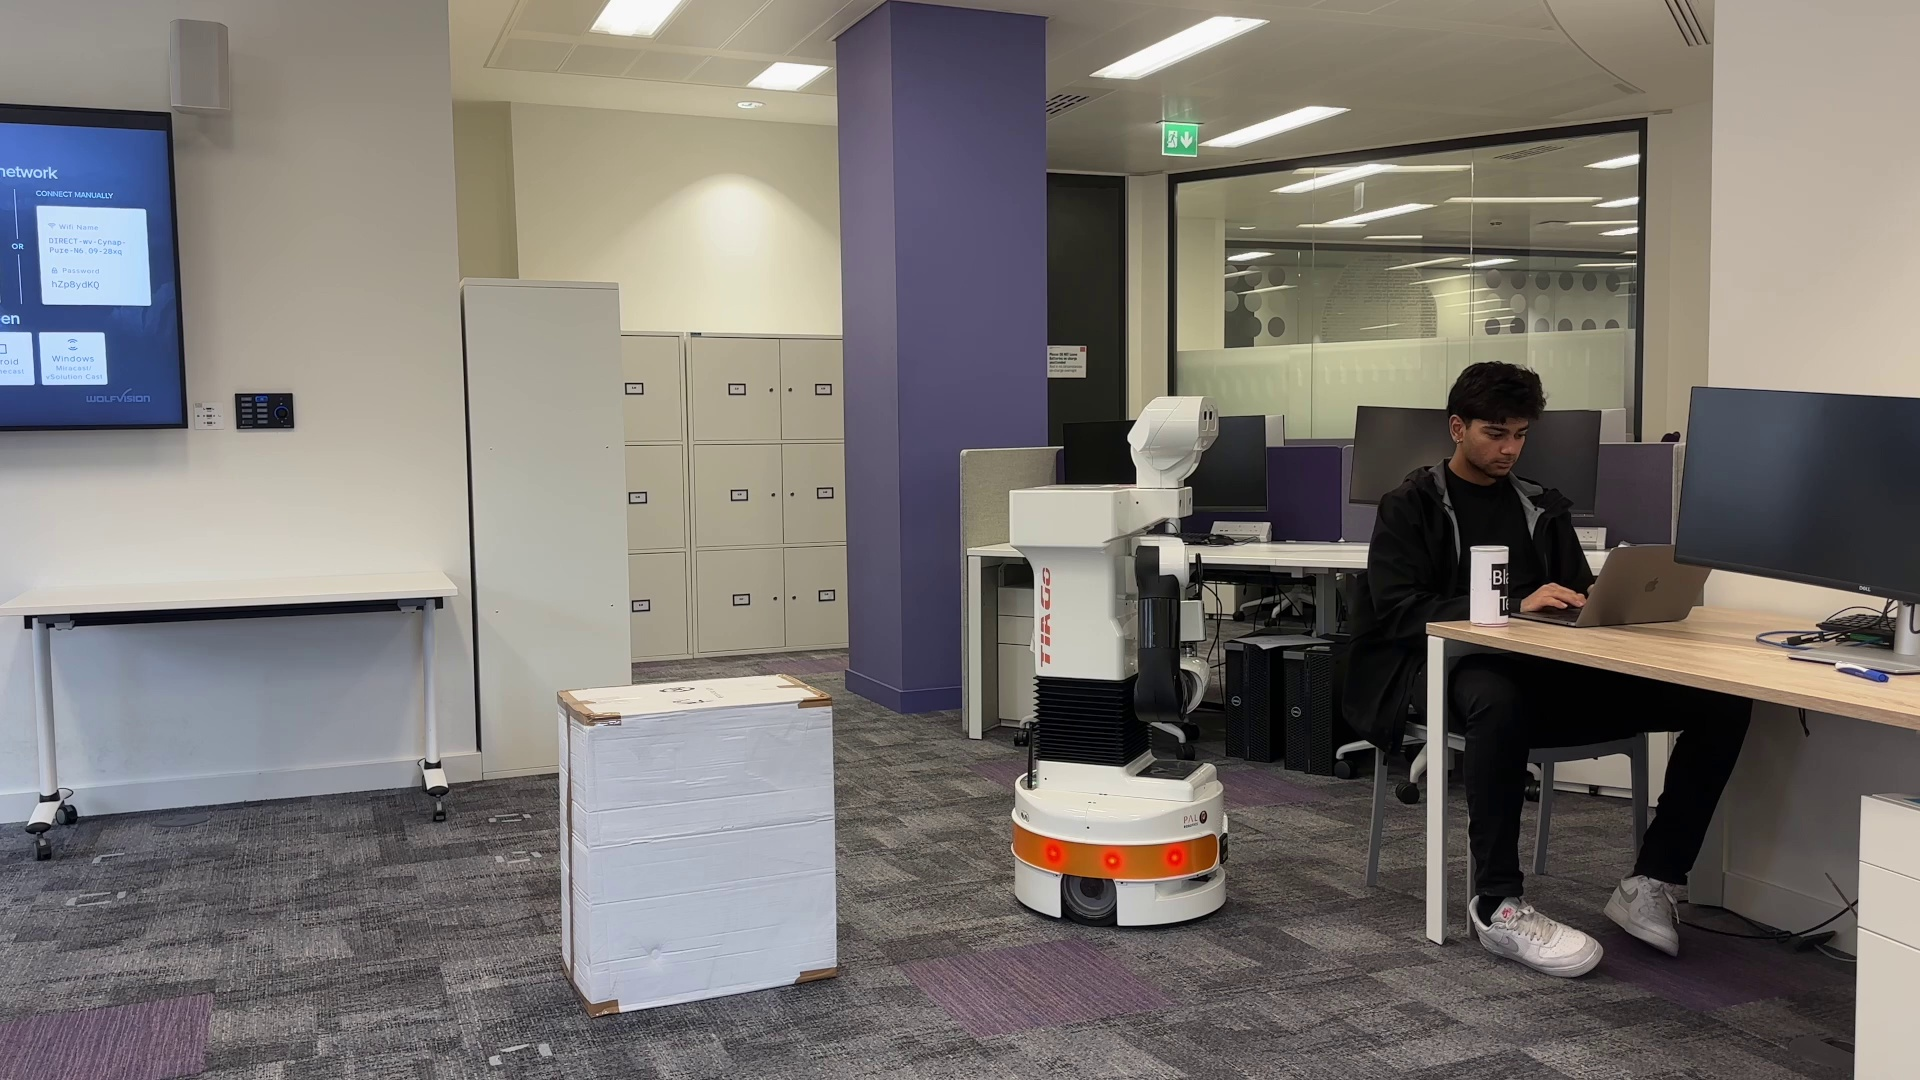

In [9]:
display_handle = display(None, display_id=True)
for i, img in enumerate(videos_base64Frames[15][::90]):
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(1)

In [24]:
lenghts=[]
for video in videos_base64Frames:
    lenghts.append(len(video[0::90]))
print("Average downsampled video length:", sum(lenghts)/len(lenghts), "frames")
print("SD:", pd.Series(lenghts).std())

Average downsampled video length: 7.6875 frames
SD: 2.868652413009751


## Video + Subtitles

Get Scenario Descriptions

In [81]:
prompt = "\n\nThese video frames and the accompanying dialogue depict a human–robot interaction. Describe what happens."
output = []
input_texts = []
for i in range(0, len(videos_base64Frames)):
    frames = videos_base64Frames[i][0::90]
    input_text = "Dialogue: " + subtitles[i] + " " + prompt
    input_texts.append(input_text)
    print(video_titles[i], input_text)
    PROMPT_MESSAGES = [
        {
            "role": "user",
            "content": [
                input_text,
                *map(lambda x: {"image": x, "resize": 768}, videos_base64Frames[i][0::90]),
            ],
        },
    ]
    params = {
        "model": "gpt-4-vision-preview",
        "messages": PROMPT_MESSAGES,
        "max_tokens": 800,
        "temperature": 0
    }
    result = client.chat.completions.create(**params)
    print("Model Output:")
    print(result.choices[0].message.content)
    output.append(result.choices[0].message.content)
    print("———————————————\n\n\n")
    time.sleep(60) # rate limit

# save the input texts, output, and video_titles to a csv file
df = pd.DataFrame(list(zip(video_titles, input_texts, output)), columns=["Video Title", "Input", "Output"])
# save 
df.to_csv("generated_video_descriptions_gpt4v.csv", index=False)

Unforseen_Path_HRI.mp4 Dialogue: User: 'Hey, can you get me some orange juice from the kitchen?' Robot: 'Yes sure. I will go.' 

These video frames and the accompanying dialogue depict a human–robot interaction. Describe what happens.
Model Output:
The sequence of images depicts a robot in an office environment interacting with a human. The human is seated at a desk with computers, and the robot approaches him. The robot is equipped with a white manipulator arm and is mounted on a mobile base with orange and white coloring. It appears to be a service robot, possibly designed to perform tasks such as fetching items.

In the first few images, the robot approaches the human, who seems to be giving it a command. The robot then turns away from the human and moves towards a door, indicating that it is responding to the human's request. As the robot reaches the door, it encounters a sign that reads "DOOR OUT OF ORDER!" This suggests that the robot's path to complete the task is obstructed, an

Get Ratings

In [74]:
model_scores = {"Apology": [], "Why-Explanation": [], "What-Explanation": [], "Next-Action": [], "Ask-for-Help": [], "Continue": []}
model_scores_cleaned = {"Apology": [], "Why-Explanation": [], "What-Explanation": [], "Next-Action": [], "Ask-for-Help": [], "Continue": []}

for key in ["Apology", "Why-Explanation", "What-Explanation", "Next-Action","Ask-for-Help","Continue"]: 
    for i, prompt in enumerate(PROMPTS[key]):
        frames = videos_base64Frames[i][0::90]
        print(video_titles[i], prompt)
        PROMPT_MESSAGES = [
            {
                "role": "user",
                "content": [
                    prompt,
                    *map(lambda x: {"image": x, "resize": 768}, videos_base64Frames[i][0::90]),
                ],
            },
        ]
        params = {
            "model": "gpt-4-vision-preview",
            "messages": PROMPT_MESSAGES,
            "max_tokens": 800,
            "temperature": 0
        }
        result = client.chat.completions.create(**params)
        #time.sleep(60) #rate limit
        print("Model Output:")
        answer = result.choices[0].message.content
        print(answer)
        model_scores[key].append(result.choices[0].message.content)
        # extract answer through 2nd prompt like in CoT
        new_prompt = "Q: "+prompt + "\nA: "+answer+"\nTherefore, the answer (number on the scale) is"
        print("2nd prompt:", new_prompt)
        second_answer = client.chat.completions.create(
                model="gpt-3.5-turbo-0613",
                messages=[ {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": new_prompt}],
                temperature=0,
                max_tokens=10,
                seed = 42, 
                )
        answer = second_answer.choices[0].message.content
        print("Extracted answer:", answer)
        model_scores_cleaned[key].append(answer)
        print("———————————————\n\n\n")
        time.sleep(60) # rate limit for OpenAI API (strict with the vision model)

scores_cleaned = {}
for key in model_scores_cleaned:
    scores_cleaned[key] = []
    for score in model_scores_cleaned[key]:
        score = score.split(" ")[0]
        try:
            scores_cleaned[key].append(float(score))
        except:
            scores_cleaned[key].append(3)

Unforseen_Path_HRI.mp4 Dialogue: User: 'Hey, can you get me some orange juice from the kitchen?' Robot: 'Yes sure. I will go.'

Given these frames and accompanying dialogue showcasing a human–robot interaction, what should the robot do next? Provide a rating on a scale from 1 (Completely Disagree) to 5 (Completely Agree) for the following statement: 'The robot should say what it is going to do next.'
Only provide the score:
Model Output:
5
2nd prompt: Q: Dialogue: User: 'Hey, can you get me some orange juice from the kitchen?' Robot: 'Yes sure. I will go.'

Given these frames and accompanying dialogue showcasing a human–robot interaction, what should the robot do next? Provide a rating on a scale from 1 (Completely Disagree) to 5 (Completely Agree) for the following statement: 'The robot should say what it is going to do next.'
Only provide the score:
A: 5
Therefore, the answer (number on the scale) is
Extracted answer: 5
———————————————



Inability_Broken_HRI.mp4 Dialogue: User: 'Can

In [75]:
# save the cleaned scores + 1 column for video titles
df = pd.DataFrame(list(zip(video_titles, scores_cleaned["Apology"], scores_cleaned["Why-Explanation"], scores_cleaned["What-Explanation"], scores_cleaned["Next-Action"], scores_cleaned["Ask-for-Help"], scores_cleaned["Continue"])), columns=["Video Title", "Apology", "Why-Explanation", "What-Explanation", "Next-Action", "Ask-for-Help", "Continue"])
# save 
df.to_csv("clean_generated_answers_gpt4v.csv", index=False)

# same for original answers
df = pd.DataFrame(list(zip(video_titles, model_scores["Apology"], model_scores["Why-Explanation"], model_scores["What-Explanation"], model_scores["Next-Action"], model_scores["Ask-for-Help"], model_scores["Continue"])), columns=["Video Title", "Apology", "Why-Explanation", "What-Explanation", "Next-Action", "Ask-for-Help", "Continue"])
df.to_csv("generated_answers_gpt4v.csv", index=False)